# Example of model selection using cross-validation with RecTools

- CV split
- Training a variety of models
- Measuring a variety of metrics

In [17]:
from pprint import pprint

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

from implicit.nearest_neighbours import TFIDFRecommender, BM25Recommender
from implicit.als import AlternatingLeastSquares

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import Precision, Recall, MeanInvUserFreq, Serendipity, calc_metrics
from rectools.models import ImplicitItemKNNWrapperModel, RandomModel, PopularModel
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.visuals import MetricsApp

## Load data

In [2]:
%%time
!wget -q https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ml-1m.zip
!unzip -o ml-1m.zip
!rm ml-1m.zip

Archive:  ml-1m.zip
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
CPU times: user 230 ms, sys: 29.9 ms, total: 260 ms
Wall time: 5.84 s


In [3]:
%%time
ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    engine="python",  # Because of 2-chars separators
    header=None,
    names=[Columns.User, Columns.Item, Columns.Weight, Columns.Datetime],
)
print(ratings.shape)
ratings.head()

(1000209, 4)
CPU times: user 7.55 s, sys: 218 ms, total: 7.77 s
Wall time: 7.82 s


,user_id,item_id,weight,datetime
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
ratings["user_id"].nunique(), ratings["item_id"].nunique()

(6040, 3706)

In [5]:
ratings["weight"].value_counts()

weight
4    348971
3    261197
5    226310
2    107557
1     56174
Name: count, dtype: int64

In [6]:
ratings["datetime"] = pd.to_datetime(ratings["datetime"] * 10 ** 9)
print("Time period")
ratings["datetime"].min(), ratings["datetime"].max()

Time period


(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

Create `Dataset` class. It's a wrapper for interactions. User and item features can also be added (see next examples for details).

In [7]:
%%time
dataset = Dataset.construct(ratings)

CPU times: user 89.9 ms, sys: 12.4 ms, total: 102 ms
Wall time: 225 ms


## Prepare cross-validation splitter

We'll use last 3 periods of 2 weeks to validate our models.

In [8]:
n_splits = 3

splitter = TimeRangeSplitter(
    test_size="14D",
    n_splits=n_splits,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

In [9]:
splitter.get_test_fold_borders(dataset.interactions)

[(Timestamp('2003-01-18 00:00:00'), Timestamp('2003-02-01 00:00:00')),
 (Timestamp('2003-02-01 00:00:00'), Timestamp('2003-02-15 00:00:00')),
 (Timestamp('2003-02-15 00:00:00'), Timestamp('2003-03-01 00:00:00'))]

For test folds left border is always included in fold and the right one is excluded.

Train folds don't have left border, and the right one is always excluded.

## Train models

In [10]:
# Take few simple models to compare
models = {
    "random": RandomModel(random_state=42),
    "popular": PopularModel(),
    "most_raited": PopularModel(popularity="sum_weight"),
    "tfidf_k=5": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=5)),
    "tfidf_k=10": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=10)),
    "bm25_k=10_k1=0.05_b=0.1": ImplicitItemKNNWrapperModel(model=BM25Recommender(K=5, K1=0.05, B=0.1)),
}

# We will calculate several classic (precision@k and recall@k) and "beyond accuracy" metrics
metrics = {
    "prec@1": Precision(k=1),
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "novelty@10": MeanInvUserFreq(k=10),
    "serendipity@10": Serendipity(k=10),
}

K_RECS = 10

In [11]:
%%time

# For each fold generate train and test part of dataset
# Then fit every model, generate recommendations and calculate metrics

cv_results = cross_validate(
    dataset=dataset,
    splitter=splitter,
    models=models,
    metrics=metrics,
    k=K_RECS,
    filter_viewed=True,
)

CPU times: user 27.1 s, sys: 259 ms, total: 27.4 s
Wall time: 15.2 s


We can get some split stats

In [12]:
pd.DataFrame(cv_results["splits"])

,i_split,start,end,train,train_users,train_items,test,test_users,test_items
0,0,2003-01-18,2003-02-01,998083,6040,3706,630,75,540
1,1,2003-02-01,2003-02-15,998713,6040,3706,899,57,704
2,2,2003-02-15,2003-03-01,999612,6040,3706,597,66,501


And the main result is metrics

In [13]:
pd.DataFrame(cv_results["metrics"])

,model,i_split,prec@1,prec@10,recall@10,novelty@10,serendipity@10
0,random,0,0.000000,0.002667,0.000832,6.520987,0.000422
1,popular,0,0.053333,0.024000,0.037410,1.580736,0.000123
2,most_raited,0,0.053333,0.026667,0.042251,1.592543,0.000151
3,tfidf_k=5,0,0.053333,0.021333,0.023866,2.361189,0.000465
4,tfidf_k=10,0,0.026667,0.021333,0.039926,2.137451,0.000327
5,bm25_k=10_k1=0.05_b=0.1,0,0.026667,0.029333,0.046645,1.781881,0.000271
6,random,1,0.017544,0.005263,0.000732,6.490783,0.000605
7,popular,1,0.052632,0.057895,0.015707,1.588414,0.000183
8,most_raited,1,0.035088,0.056140,0.009919,1.600628,0.000155
9,tfidf_k=5,1,0.052632,0.057895,0.048591,2.326116,0.002616


Let's now aggregate metrics by folds and compare models

In [14]:
pivot_results = (
    pd.DataFrame(cv_results["metrics"])
    .drop(columns="i_split")
    .groupby(["model"], sort=False)
    .agg(["mean"])
)
pivot_results.columns = pivot_results.columns.droplevel(1)

(
    pivot_results.style
    .set_caption("Mean values of metrics")
    .highlight_min(color='lightcoral', axis=0)
    .highlight_max(color='lightgreen', axis=0)
)

,prec@1,prec@10,recall@10,novelty@10,serendipity@10
model,,,,,
random,0.010898,0.003653,0.000813,6.449487,0.000535
popular,0.050473,0.041440,0.031034,1.608596,0.000252
most_raited,0.044625,0.040734,0.025564,1.620426,0.000213
tfidf_k=5,0.065625,0.043076,0.037354,2.355431,0.001527
tfidf_k=10,0.046635,0.041827,0.034497,2.162626,0.000863
bm25_k=10_k1=0.05_b=0.1,0.062584,0.042792,0.031797,1.830871,0.000337


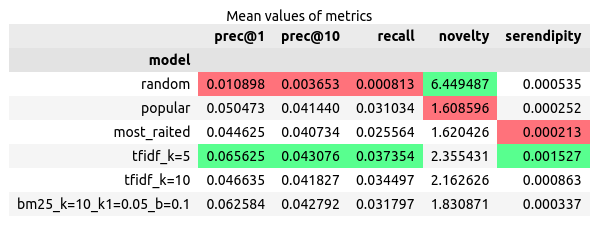

In RecTools we have interactive `MetricsApp` for detailed analysis of metrics trade-off between different models.
`visuals` extension is required to run the path of code below. You can install it with `pip install rectools[visuals]`

In [15]:
app = MetricsApp.construct(pd.DataFrame(cv_results["metrics"]))

If you run this notebook, you will get **interactive** widgets with active buttons to select metrics and folds. For offline presentation we keep **static** screenshots of the actual app.

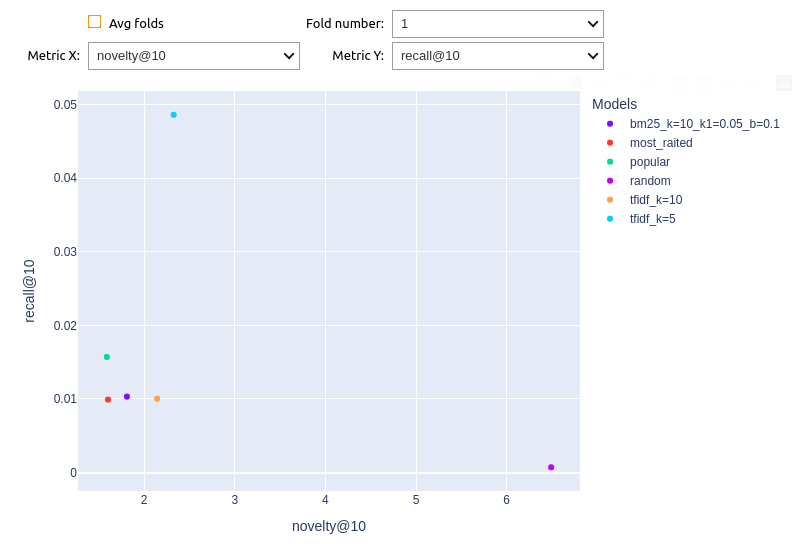

If you want to save static image from your app, you can access `plotly.graph_objs.Figure` and render it as an image. Make sure you have `kaleido` package to process rendering. You can install it with `pip install kaleido==0.2.1` and restart the kernel.

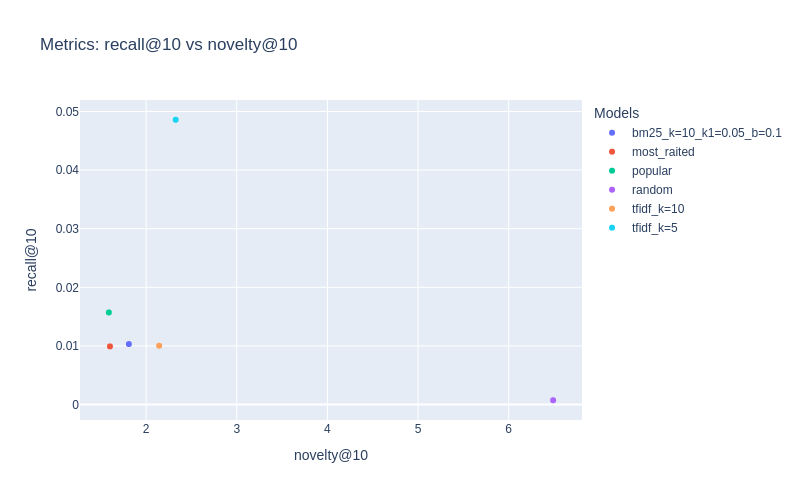

In [19]:
fig = app.fig
fig.update_layout(
    title="Metrics: recall@10 vs novelty@10",
    margin=None, #  reset chart margins to default
)
fig.show("png")